In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import mne

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, find_events, pick_types, set_eeg_reference
from mne.channels import read_layout
from mne.io import concatenate_raws, read_raw_edf
from mne import viz

from datetime import datetime

%matplotlib inline 

# Required Libraries:
# MNE (EEG Analysis and Visualization): https://mne.tools/stable/index.html
# Pandas
# Numpy

In [59]:
# Dataset: CAP Sleep DB

# Quick Notes/Research:
# EEG (electroencephalogram - brain) Channels are called "C4-A1" and "C3-A2," according to the derivations based on the 10-20 system.
# These correspond to the potential at C4 Referenced to A1 (Behind the left ear). C3 Referenced to A2 (Behind the right ear)

# The EOC (electrooculography - eyes) channel is called "ROC-LOC" for a bipolar derivation between electrodes on the right and left of the eyes.
# The EMG (electromyography - muscles) is "EMG1-EMG2" for a bipolar derivation between two electrodes on the muscles of the chin.
# The ECG (electrocardiogram - heart) channel is called "ECG1-ECG2." 

# Data of all channels were notch filtered at 5 Hz and the EEG, ECG, and EOG was filted with a highpass of 0.3 Hz and a low-pass of 30 Hz.
# EMG was already high-pass filtered at 10 Hz and low-pass filtered at 100 Hz.

# Data consist of 16 healthy subjects and 92 subjects with some pathological recording. 
# Every subject has waveforms recorded every 0.0019531 seconds (https://physionet.org/lightwave/?db=capslpdb/1.0.0)

# First Subject (n1) has waveforms recorded every 0.0019531 (0.002) seconds to a total of 17,725,440 data points. Using these data, we'll need to feature
# engineer to get the feature matrix.

# Since data is collected for 108 nights and be to different patients with different psychological conditions. 
# However, for the sake of this study, we'll only consider the data for a healthy psychology in the first part. 

# Step one: Clean the dataset
# Reminder: Training data set of the FIRST patient (n1) has 17,725,440 data points, each separated at fixed time interval of 0.0019531 seconds. I'm
# only using the EEG reading which is the F2-F4 signals.

# The Data start time and duration is located in a separate file. Both of these data files will be combined into a signal data file by labeling each data
# point in the EEG dataset with information about the presence of the CAP cycle. 

# Goal: Create a data file with three columns: 1. Absolute time in seconds at which the reading is recorded, 2. Actual EEG reading in (Microvolts), 
#3. Binary representations (0 or 1) where 0 indicates absence of Phase A at the given time and 1 indicate presence of phase A.

In [16]:
# [ CHANGE PARAMETERS HERE and the PATHING on line 9 and 69]
patient_number = 3
signs_per_label = 15360
remove_front = 1244160
remove_back = 151872
remove_throughout = 48

# Setup pathing, data file, and lable file.
data_path = os.path.join('.', 'C:/Users/Harry/Desktop/ECEC487/data/data')
data_file = os.path.join(data_path, 'n{}.edf'.format(patient_number))
label_file = os.path.join(data_path, 'n{}.csv'.format(patient_number))

# Setup Labels
data = pd.read_csv(label_file)
data['Label']  # as a Series

# Labels: W (Wake) = 0, S1-S3 (nREM) = 1, S4/R (REM) = 2
labels = data['Label'].values  # as a numpy array

# Replace string label to value representation:
for i in range (0, len(labels)):
    if labels[i] in ('W'):
        labels[i] = 0
    elif labels[i] in ('S1', 'S2', 'S3'):
        labels[i] = 1
    elif labels[i] in ('S4', 'R'):
        labels[i] = 2
        
# Setup Data
# Read/Load EDF for EEG Signal
raw = mne.io.read_raw_edf(data_file)

# Output Data Information
#print(raw.info)
#print ('Channel Names:', raw.info["ch_names"][:10])

# Get matrix array from EEG in EDF file. 
# Convert raw matrix to DataFrame - easier to visualize/format
df = raw.to_data_frame(picks=['F4-C4', 'C4-P4', 'P4-O2', 'C4-A1']);

# Remove data from beginning and end because of offset. 
# Adjust dataset to remove excess data. Needed to match label.
df = df.iloc[remove_front:-remove_back]

# Remove x data after offset to match Label file. 
df = df.drop(df.iloc[::remove_throughout].index, 0)

# Print Total Data
print("Total Data: {}".format(df.shape[0]))

# Set temporary labels to 0
df['Label'] = pd.Series(0, index=df.index)

# Force Index start at 0.
df = df.reset_index(drop=True)

label_idx = 0
idx = 0
# Change label for every x signal blocks
print ('Changing Labels')

while (idx < df.shape[0]):
    # Change Label (column 1) for every x signal block
    df.iloc[idx:idx+signs_per_label, 4] = labels[label_idx]
    
    # [DEBUG]
    #print ('[UPDATED] Index: {} Label: {}'.format(idx, df['Label'][idx]))
    #print ('Done {}'.format(idx))
    
    idx = idx + signs_per_label # Set new signal block
    label_idx += 1 # Increment Index in Label Array
    
# Drop row if label is '0 or W'
#df.drop(df.loc[df['Label']==3].index, inplace=True)

# Print Total Data
#print("Total Data (after removal): {}".format(df.shape[0]))

print ('Outputting Final Changes')   
print(df)

# Save extracted dataframe to CSV
print ('Converting Dataframe into CSV')   
export_csv = df.to_csv (r'C:/Users/Harry/Desktop/ECEC487/data/preprocessed_n{}.csv'.format(patient_number), index = True, header=True)

print("Data Processing for n{}.edf is done!".format(patient_number))

Extracting EDF parameters from C:\Users\Harry\Desktop\ECEC487\data\data\n3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Converting "time" to "<class 'numpy.int64'>"...
Total Data: 15207633
Changing Labels
Outputting Final Changes
channel      F4-C4      C4-P4      P4-O2      C4-A1  Label
0         2.915140  16.559829 -15.094628 -16.163004      0
1         2.487790  16.010379 -15.552503 -20.283883      0
2         2.060440  15.552503 -15.918803 -22.878510      0
3         1.694139  15.247253 -16.132479 -24.618437      0
4         1.449939  15.125153 -16.193529 -25.961538      0
5         1.388889  15.094628 -16.132479 -27.029915      0
6         1.419414  15.094628 -16.010379 -28.647741      0
7         1.388889  15.033578 -15.888278 -30.815018      0
8         1.297314  14.880952 -15.705128 -32.463370      0
9         1.144689  14.667277 -15.399878 -32.829670      0
10        0.992063  14.484127 -15.003053 -32.127595      0
11        0.86996

Extracting EDF parameters from C:\Users\Harry\Desktop\ECEC487\data\data\n3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Channel Names: ['Fp2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'F8-T4', 'T4-T6', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'F7-T3', 'T3-T5', 'C4-A1', 'ROC-LOC', 'EMG1-EMG2']
Converting "time" to "<class 'numpy.int64'>"...


"\nplt.legend([raw.ch_names[0], raw.ch_names[1],raw.ch_names[2], raw.ch_names[3],raw.ch_names[4], raw.ch_names[5]\n            ,raw.ch_names[6], raw.ch_names[7],raw.ch_names[8], raw.ch_names[9],raw.ch_names[10], raw.ch_names[11],\n            raw.ch_names[12]], loc='upper right')"

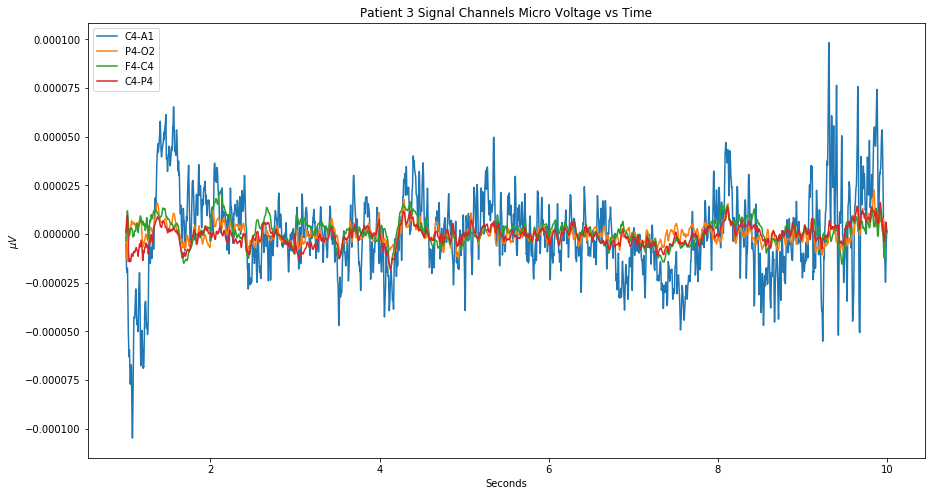

In [12]:
# Setup pathing, data file, and lable file.
patient_number = 3;
data_path = os.path.join('.', 'C:/Users/Harry/Desktop/ECEC487/data/data')
data_file = os.path.join(data_path, 'n{}.edf'.format(patient_number))
label_file = os.path.join(data_path, 'n{}.csv'.format(patient_number))

# Setup Data
# Read/Load EDF for EEG Signal
raw = mne.io.read_raw_edf(data_file)

# Output Data Information
#print(raw.info)
print ('Channel Names:', raw.info["ch_names"][:15])

# Get matrix array from EEG in EDF file. 
# Convert raw matrix to DataFrame - easier to visualize/format
df = raw.to_data_frame(picks=['F4-C4', 'C4-P4', 'P4-O2', 'C4-A1']);
#df = raw.to_data_frame();

# Visualize Data
sfreq = raw.info['sfreq']
"""
data1, times1 = raw[0, int(sfreq * 1):int(sfreq * 10)] #F4-C4
data2, times2 = raw[1, int(sfreq * 1):int(sfreq * 10)] #C4-P4
data3, times3 = raw[2, int(sfreq * 1):int(sfreq * 10)] #P4-O2
data4, times4 = raw[3, int(sfreq * 1):int(sfreq * 10)] #C4-A1
data5, times5 = raw[4, int(sfreq * 1):int(sfreq * 10)] #F4-C4
data6, times6 = raw[5, int(sfreq * 1):int(sfreq * 10)] #C4-P4
data7, times7 = raw[6, int(sfreq * 1):int(sfreq * 10)] #P4-O2
data8, times8 = raw[7, int(sfreq * 1):int(sfreq * 10)] #C4-A1
data9, times9 = raw[8, int(sfreq * 1):int(sfreq * 10)] #F4-C4
data10, times10 = raw[9, int(sfreq * 1):int(sfreq * 10)] #C4-P4
data11, times11 = raw[10, int(sfreq * 1):int(sfreq * 10)] #P4-O2
data12, times12 = raw[11, int(sfreq * 1):int(sfreq * 10)] #C4-A1
data0, times0 = raw[0, int(sfreq * 1):int(sfreq * 10)] #C4-A1

fig = plt.subplots(figsize=(15,8))
plt.plot(times0, data0.T);
plt.plot(times1, data1.T);
plt.plot(times2, data2.T);
plt.plot(times3, data3.T);
plt.plot(times4, data4.T);
plt.plot(times5, data5.T);
plt.plot(times6, data6.T);
plt.plot(times7, data7.T);
plt.plot(times8, data8.T);
plt.plot(times9, data9.T);
plt.plot(times10, data10.T);
plt.plot(times11, data11.T);
plt.plot(times12, data12.T);
"""

data1, times1 = raw[12, int(sfreq * 1):int(sfreq * 10)] #F4-C4
data2, times2 = raw[3, int(sfreq * 1):int(sfreq * 10)] #C4-P4
data3, times3 = raw[1, int(sfreq * 1):int(sfreq * 10)] #P4-O2
data4, times4 = raw[2, int(sfreq * 1):int(sfreq * 10)] #C4-A1

fig = plt.subplots(figsize=(15,8))
plt.plot(times1, data1.T);
plt.plot(times2, data2.T);
plt.plot(times3, data3.T);
plt.plot(times4, data4.T);

plt.xlabel('Seconds')
plt.ylabel('$\mu V$')
plt.title('Patient 3 Signal Channels Micro Voltage vs Time');
plt.legend([raw.ch_names[12], raw.ch_names[3], raw.ch_names[1], raw.ch_names[2]]);

"""
plt.legend([raw.ch_names[0], raw.ch_names[1],raw.ch_names[2], raw.ch_names[3],raw.ch_names[4], raw.ch_names[5]
            ,raw.ch_names[6], raw.ch_names[7],raw.ch_names[8], raw.ch_names[9],raw.ch_names[10], raw.ch_names[11],
            raw.ch_names[12]], loc='upper right')"""